In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import cv2
import os
from PIL import Image

#VGG16
from keras.applications.vgg16 import VGG16

#ResNet
from tensorflow.keras.applications import ResNet50

#Lab scripts
import plot_helper
import cnn_helper

In [3]:
base_directory = "/home/jovyan/big-data_deeplearning/"

## Set up where to find our data
labels_path = base_directory + "Assignments/Class Labels of Dataset 1.csv"
images_path = base_directory + "LabData/bloodcells_seg/images/all/"

balanced_images_path = base_directory + "LabData/bloodcells_seg/balanced_images/"

df_labels = pd.read_csv(labels_path) 

In [4]:
for ID in df_labels['image ID']:
    if int(ID) < 10:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '000' + str(ID) + '.png')
    elif int(ID) < 100:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '00' + str(ID) + '.png')
    elif int(ID) < 1000:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '0' + str(ID) + '.png')
        
for label in df_labels['class label']:
    df_labels['class label'] = df_labels['class label'].replace([int(label)], str(label))

df_labels

,image ID,class label
0,0001.png,2
1,0002.png,1
2,0003.png,1
3,0004.png,1
4,0005.png,1
...,...,...
295,0296.png,4
296,0297.png,4
297,0298.png,4
298,0299.png,1


In [5]:
print(df_labels['class label'].value_counts())
df_labels = df_labels[df_labels['class label'] != '5']

print(df_labels['class label'].value_counts())


1    176
2     53
3     48
4     22
5      1
Name: class label, dtype: int64
1    176
2     53
3     48
4     22
Name: class label, dtype: int64


In [6]:
class_column_header = "class label"
df_labels_to_use = df_labels.copy() # We're copying the df_labels so that you can look at the original again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2

# fixed script to actually provide datasets without overlap, so that overfitting for the training data does not
# affect the evaluation of the model.
df_test = df_labels_to_use.groupby(class_column_header).sample(frac=test_set_fraction)
df_remainder = df_labels_to_use.drop(df_test.index)
df_validation = df_remainder.groupby(class_column_header).sample(frac=validation_set_fraction)
df_train = df_remainder.drop(df_validation.index)

In [7]:
print("Number of samples: %d" % len(df_labels_to_use.index))
print("Number of training samples: %d" % len(df_train.index))
print("Number of test samples: %d" % len(df_test.index))
print("Number of validation samples: %d" % len(df_validation.index))

Number of samples: 299
Number of training samples: 214
Number of test samples: 30
Number of validation samples: 55


In [8]:
#################################################################
#              Balancing the Dataset
#################################################################
## To balance the dataset, we apply data augmentation using random sampling.

## we only want to do data augmentation on the training data.
df_train_balanced = df_train.copy()

# Calculate the weight of each class in the train dataset.
weights = df_train_balanced['class label'].value_counts()
desired_samples_per_class = 230  # shouldn't be bigger than 234, or the names are going to crash
print(weights)

## ImageDataGenerator for data augmentation
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 90,
                                                                   width_shift_range = 0.05,
                                                                   height_shift_range = 0.05,
                                                                   shear_range = 0.1,
                                                                   zoom_range = 0.1,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True,
                                                                   brightness_range = [0.8,1.2])

## Iterate to create new images from the existing ones until the dataset is balanced.
last_name = 300
for class_label in weights.index:
    samples_in_class = len(df_train_balanced[df_train_balanced['class label'] == class_label])
    
    while samples_in_class < desired_samples_per_class:
        last_name += 1
        ## We load the images to augmentate from the normal direcotry, since we only want to augmentate original images.
        ran_image_from_class_name = df_train[df_train['class label'] == class_label].sample(1)
        image = Image.open(images_path+str(ran_image_from_class_name.iloc[0]['image ID']))
        array_image = np.array(image)
        
        ## create the new randomly modiffied image usgin the data augmentation defined.
        array_image = np.expand_dims(array_image, 0) # we need to turn the image from matrix to tensor, otherwise the flow crashes.
        batch = train_data_generator.flow(array_image, batch_size = 1).next()
        new_image = batch[0].astype('uint8')
        
        ## save the image with the new name and add it to the dataframe of training data.
        new_image_name = "0" + str(last_name) + ".png"
        keras.preprocessing.image.save_img(balanced_images_path + new_image_name, new_image)
        df_train_balanced = pd.concat([df_train_balanced, pd.DataFrame({'image ID': [new_image_name], 'class label': [class_label]})])
        
        samples_in_class += 1

print(df_train_balanced['class label'].value_counts())

1    126
2     38
3     34
4     16
Name: class label, dtype: int64
2    230
1    230
3    230
4    230
Name: class label, dtype: int64


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image ID". These filename(s) will be ignored.
  warnings.warn(


Found 919 validated image filenames belonging to 4 classes.
Found 55 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - 7s 2s/step - loss: 25.0769 - categorical_accuracy: 0.2513 - val_loss: 16.2866 - val_categorical_accuracy: 0.1273
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 15.9766 - categorical_accuracy: 0.2866 - val_loss: 11.8772 - val_categorical_accuracy: 0.0727
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 10.7146 - categorical_accuracy: 0.3008 - val_loss: 3.2913 - val_categorical_accuracy: 0.4545
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 8.4145 - categorical_accuracy: 0.2812 - val_loss: 3.6538 - val_categorical_accuracy: 0.2545
Epoch 5/100
3/3 [==============================] - 5s 1s/step - loss: 6.1153 - categorical_accuracy: 0.3137 - val_loss: 2.6181 - val_categorical_accuracy: 0.2545
Epoch 6

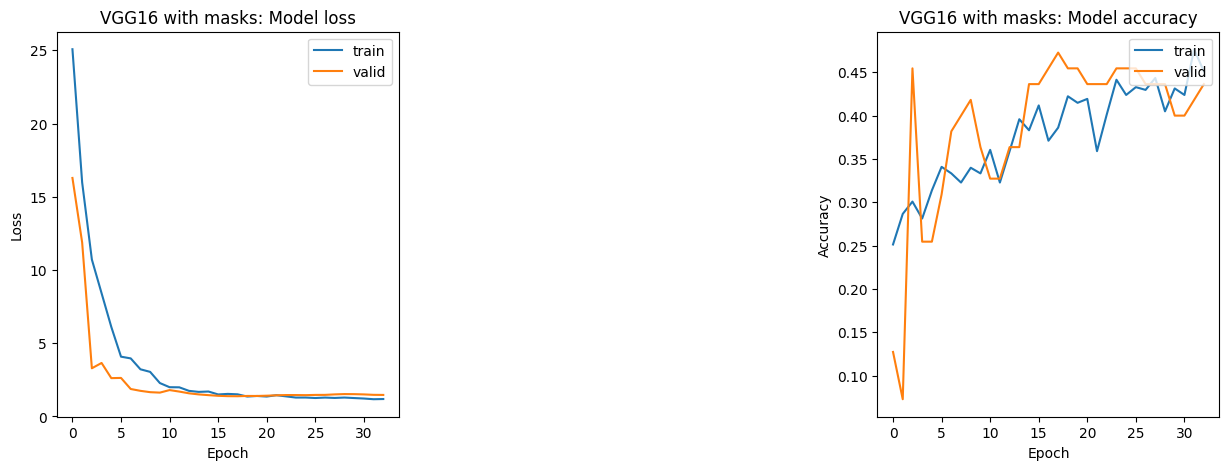



TEST CONFUSION MATRIX
Accuracy on the validation dataset: 0.36666666666666664


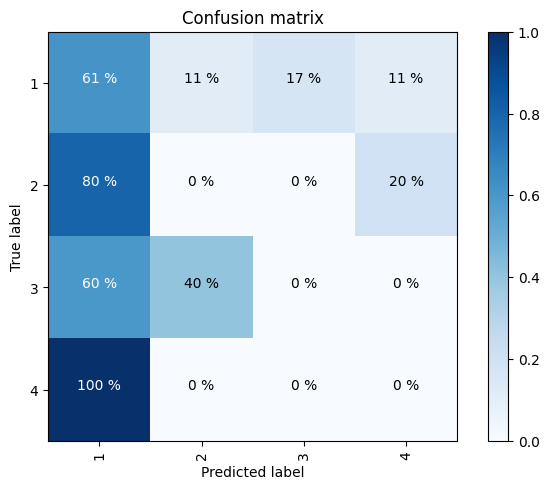

VALIDATION CONFUSION MATRIX
Accuracy on the validation dataset: 0.4727272727272727


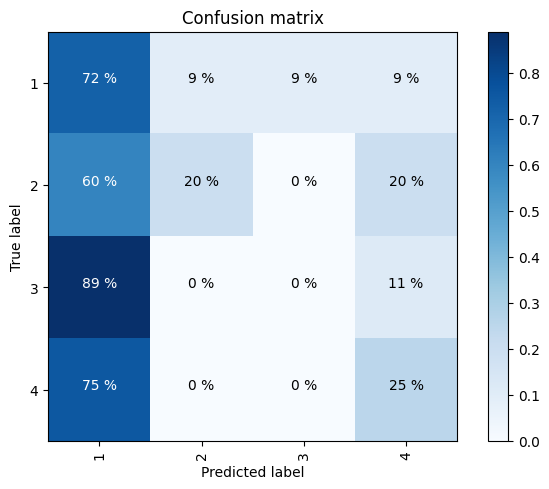

In [25]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 256 
image_shape = (128, 128, 3) # we need to add an extra channel for the mask
filename_column = 'image ID'
true_label_column = "class label"

## Data generator with data augmentation preprocessing for the training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input,
                                                                    rotation_range = 90,
                                                                   width_shift_range = 0.05,
                                                                   height_shift_range = 0.05,
                                                                   shear_range = 0.1,
                                                                   zoom_range = 0.1,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True,
                                                                   brightness_range = [0.8,1.2])
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)

## NOT SURE IF WITH THIS DATA AUGMENTATION, THE DATASET IS STILL UNBALANCED, OR IF THAT GETS FIXED.

train_generator = train_data_generator.flow_from_dataframe(
    df_train_balanced, directory=balanced_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      VGG16 model
#################################################################
## Not sure if the way that we proceeded is the intended, but since VGG16 can only intake images with 3 channels, we tried to
## process the mask in paralel.

VGG16_base_model = keras.applications.VGG19(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False, pooling=None,)

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False





# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)





# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Early Stopping and saving the best model that we get during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
save_best_model = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

## Actually train model
epochs = 100
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    callbacks = [early_stop, save_best_model])

best_model = keras.models.load_model('best_model.h5')



#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = best_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16 with masks")
print("\n")

## Confussion Matrix
print("TEST CONFUSION MATRIX")
cnn_helper.plot_confusion_matrix_from_generator(best_model, test_generator)
print("VALIDATION CONFUSION MATRIX")
cnn_helper.plot_confusion_matrix_from_generator(best_model, valid_generator)
